                       Category  Count
0       Original mentions (all)  24581
1     Retraction mentions (all)  11304
2    Before-Retraction Original  13300
3     After-Retraction Original  11650
4  Before-Retraction Retraction   2123
5   After-Retraction Retraction   9137
6      Strict (URL) Co-mentions   6254
7     Overlap (any URL in both)   7680


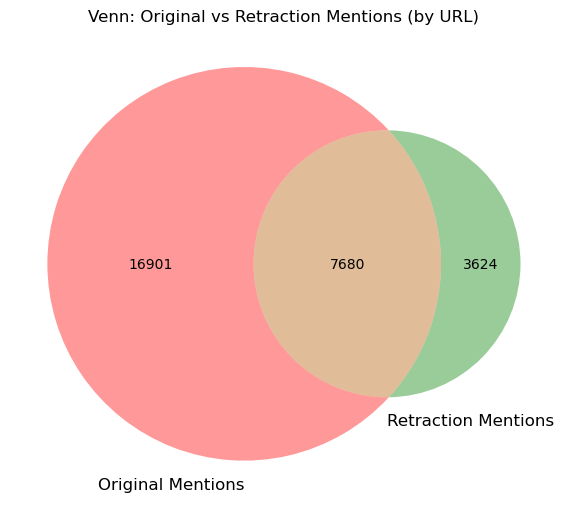

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from pathlib import Path

PATH_MASTER = "dataset_14_08_2025_completion.csv"
PATH_ORIG   = "mentions_original_fill_cleaned.csv"
PATH_RETR   = "mentions_retraction_fill_cleaned.csv"
STRICT_PATH = "co_mention_strict_only/strict_url_details.csv"

OUT = Path("mentions_dashboard")
OUT.mkdir(exist_ok=True)

def norm_str(x):
    if pd.isna(x): return np.nan
    x = str(x).strip()
    return np.nan if x in {"", "0", "nan", "NaN", "none", "None", "null", "Null"} else x

def norm_doi(x):
    x = norm_str(x)
    if pd.isna(x): return np.nan
    x = x.lower()
    if x.startswith("doi:"):
        x = x[4:].strip()
    return x

def canonical_url(x):
    x = norm_str(x)
    if pd.isna(x): return np.nan
    x = x.strip()
    if "#" in x:
        x = x.split("#", 1)[0]
    return x

master = pd.read_csv(PATH_MASTER, dtype=str, keep_default_na=False)
for c in ["OriginalPaperDate","RetractionDate"]:
    master[c] = pd.to_datetime(master[c], errors="coerce", utc=True)
master["orig_doi_norm"] = master["OriginalPaperDOI"].map(norm_doi)
master["retr_doi_norm"] = master["RetractionDOI"].map(norm_doi)
map_origdoi_to_retrdate = (
    master.dropna(subset=["orig_doi_norm","RetractionDate"])
          .groupby("orig_doi_norm")["RetractionDate"].min()
)
map_retrdoi_to_retrdate = (
    master.dropna(subset=["retr_doi_norm","RetractionDate"])
          .groupby("retr_doi_norm")["RetractionDate"].min()
)

orig = pd.read_csv(PATH_ORIG, dtype=str, keep_default_na=False)
retr = pd.read_csv(PATH_RETR, dtype=str, keep_default_na=False)

for df in (orig, retr):
    df["Mention Date"] = pd.to_datetime(df["Mention Date"], errors="coerce", utc=True)
    df["DOI"] = df["DOI"].map(norm_doi)
    df["Mention URL"] = df["Mention URL"].map(canonical_url)

orig["RetractionDate"] = orig["DOI"].map(map_origdoi_to_retrdate)
orig["delay_days"] = (orig["Mention Date"] - orig["RetractionDate"]).dt.days
retr["RetractionDate"] = retr["DOI"].map(map_retrdoi_to_retrdate)
retr["delay_days"] = (retr["Mention Date"] - retr["RetractionDate"]).dt.days

orig_before = orig[(orig["delay_days"] < 0) & orig["delay_days"].notna()]
orig_after  = orig[(orig["delay_days"] >= 0) & orig["delay_days"].notna()]
retr_before = retr[(retr["delay_days"] < 0) & retr["delay_days"].notna()]
retr_after  = retr[(retr["delay_days"] >= 0) & retr["delay_days"].notna()]

urls_orig_all = set(orig["Mention URL"].dropna())
urls_retr_all = set(retr["Mention URL"].dropna())
urls_orig_before = set(orig_before["Mention URL"].dropna())
urls_orig_after  = set(orig_after["Mention URL"].dropna())
urls_retr_before = set(retr_before["Mention URL"].dropna())
urls_retr_after  = set(retr_after["Mention URL"].dropna())

strict_df = pd.read_csv(STRICT_PATH)
urls_strict = set(strict_df.loc[strict_df["type"]=="STRICT_URL","url_norm"].dropna())

urls_overlap = urls_orig_all & urls_retr_all
urls_retr_before_in_orig = urls_retr_before & urls_orig_all
urls_retr_after_in_orig  = urls_retr_after & urls_orig_all

summary = pd.DataFrame([
    {"Category":"Original mentions (all)", "Count":len(urls_orig_all)},
    {"Category":"Retraction mentions (all)", "Count":len(urls_retr_all)},
    {"Category":"Before-Retraction Original", "Count":len(urls_orig_before)},
    {"Category":"After-Retraction Original", "Count":len(urls_orig_after)},
    {"Category":"Before-Retraction Retraction", "Count":len(urls_retr_before)},
    {"Category":"After-Retraction Retraction", "Count":len(urls_retr_after)},
    {"Category":"Strict (URL) Co-mentions", "Count":len(urls_strict)},
    {"Category":"Overlap (any URL in both)", "Count":len(urls_overlap)},
])
summary.to_csv(OUT/"mentions_overall_summary.csv", index=False)
print(summary)

plt.figure(figsize=(6,6))
venn2(
    subsets=(len(urls_orig_all - urls_retr_all),
             len(urls_retr_all - urls_orig_all),
             len(urls_overlap)),
    set_labels=('Original Mentions','Retraction Mentions')
)
plt.title("Venn: Original vs Retraction Mentions (by URL)")
plt.tight_layout()
plt.savefig(OUT/"venn_orig_retr.png")
plt.show()

Original segmented table:
                                     Bar  Count
0                       Before-Original  13300
1                 After-Original (base)   5847
2  After-Original (added: ∩ Retraction)   5803 

Retraction segmented table:
                                      Bar  Count
0               Before-Retraction (base)    300
1  Before-Retraction (added: ∩ Original)   1823
2                       After-Retraction   9137 



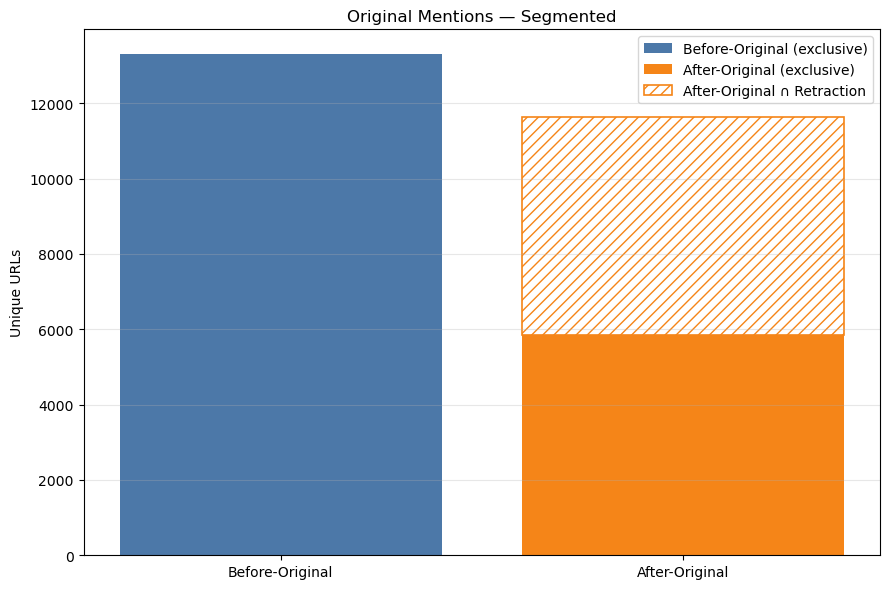

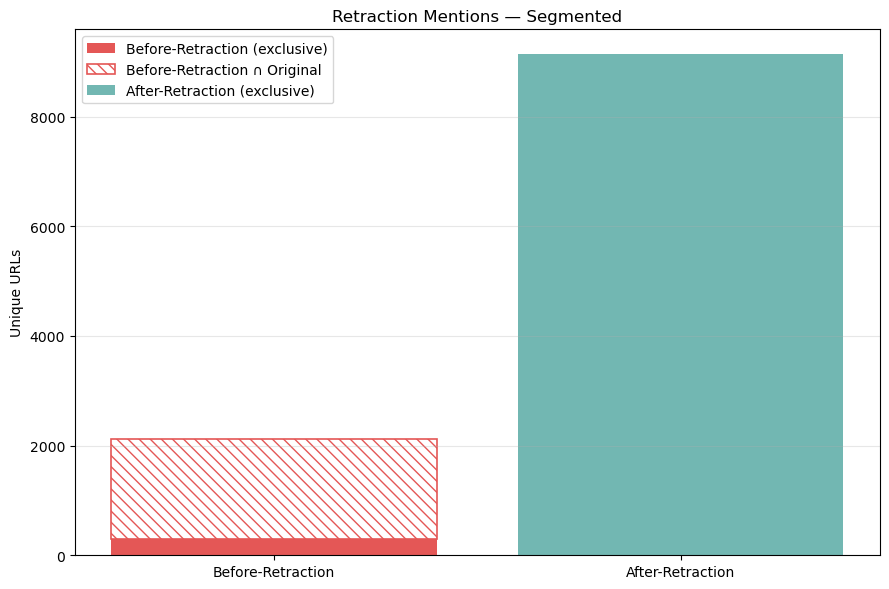

Saved figures & tables to: /Users/miaoyixuan/CS58/mentions_dashboard


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

PATH_MASTER = "dataset_14_08_2025_completion.csv"
PATH_ORIG   = "mentions_original_fill_cleaned.csv"
PATH_RETR   = "mentions_retraction_fill_cleaned.csv"

OUT = Path("mentions_dashboard")
OUT.mkdir(exist_ok=True)

def norm_str(x):
    if pd.isna(x): return np.nan
    x = str(x).strip()
    return np.nan if x in {"", "0", "nan", "NaN", "none", "None", "null", "Null"} else x

def norm_doi(x):
    x = norm_str(x)
    if pd.isna(x): return np.nan
    x = x.lower()
    if x.startswith("doi:"):
        x = x[4:].strip()
    return x

def canonical_url(x):
    x = norm_str(x)
    if pd.isna(x): return np.nan
    x = x.strip()
    if "#" in x:
        x = x.split("#", 1)[0]
    return x

master = pd.read_csv(PATH_MASTER, dtype=str, keep_default_na=False)
for c in ["OriginalPaperDate","RetractionDate"]:
    master[c] = pd.to_datetime(master[c], errors="coerce", utc=True)

master["orig_doi_norm"] = master["OriginalPaperDOI"].map(norm_doi)
master["retr_doi_norm"] = master["RetractionDOI"].map(norm_doi)

map_origdoi_to_retrdate = (
    master.dropna(subset=["orig_doi_norm","RetractionDate"])
          .groupby("orig_doi_norm")["RetractionDate"].min()
)
map_retrdoi_to_retrdate = (
    master.dropna(subset=["retr_doi_norm","RetractionDate"])
          .groupby("retr_doi_norm")["RetractionDate"].min()
)

orig = pd.read_csv(PATH_ORIG, dtype=str, keep_default_na=False)
retr = pd.read_csv(PATH_RETR, dtype=str, keep_default_na=False)

for df in (orig, retr):
    df["Mention Date"] = pd.to_datetime(df["Mention Date"], errors="coerce", utc=True)
    df["DOI"] = df["DOI"].map(norm_doi)
    df["Mention URL"] = df["Mention URL"].map(canonical_url)

orig["RetractionDate"] = orig["DOI"].map(map_origdoi_to_retrdate)
orig["delay_days"] = (orig["Mention Date"] - orig["RetractionDate"]).dt.days

retr["RetractionDate"] = retr["DOI"].map(map_retrdoi_to_retrdate)
retr["delay_days"] = (retr["Mention Date"] - retr["RetractionDate"]).dt.days

orig_before = orig[(orig["delay_days"] < 0) & orig["delay_days"].notna()]
orig_after  = orig[(orig["delay_days"] >= 0) & orig["delay_days"].notna()]

retr_before = retr[(retr["delay_days"] < 0) & retr["delay_days"].notna()]
retr_after  = retr[(retr["delay_days"] >= 0) & retr["delay_days"].notna()]

urls_orig_all    = set(orig["Mention URL"].dropna())
urls_retr_all    = set(retr["Mention URL"].dropna())
urls_orig_before = set(orig_before["Mention URL"].dropna())
urls_orig_after  = set(orig_after["Mention URL"].dropna())
urls_retr_before = set(retr_before["Mention URL"].dropna())
urls_retr_after  = set(retr_after["Mention URL"].dropna())

co_afterOrig_with_retr   = urls_orig_after  & urls_retr_all    
co_beforeRetr_with_orig  = urls_retr_before & urls_orig_all    

beforeO_exclusive = urls_orig_before
afterO_exclusive  = urls_orig_after - co_afterOrig_with_retr   

beforeR_exclusive = urls_retr_before - co_beforeRetr_with_orig 
afterR_exclusive  = urls_retr_after

df_original_view = pd.DataFrame({
    "Bar":      ["Before-Original", "After-Original (base)", "After-Original (added: ∩ Retraction)"],
    "Count":    [len(beforeO_exclusive), len(afterO_exclusive), len(co_afterOrig_with_retr)]
})
df_original_view.to_csv(OUT/"segmented_original_same_side.csv", index=False)

df_retraction_view = pd.DataFrame({
    "Bar":      ["Before-Retraction (base)", "Before-Retraction (added: ∩ Original)", "After-Retraction"],
    "Count":    [len(beforeR_exclusive), len(co_beforeRetr_with_orig), len(afterR_exclusive)]
})
df_retraction_view.to_csv(OUT/"segmented_retraction_same_side.csv", index=False)

print("Original segmented table:\n", df_original_view, "\n")
print("Retraction segmented table:\n", df_retraction_view, "\n")

plt.figure(figsize=(9,6))
x_positions = np.arange(2)

before_base = len(beforeO_exclusive)
plt.bar(x_positions[0], before_base, label="Before-Original (exclusive)", color="#4C78A8")

after_base  = len(afterO_exclusive)
after_add   = len(co_afterOrig_with_retr)
plt.bar(x_positions[1], after_base, color="#F58518", label="After-Original (exclusive)")
plt.bar(x_positions[1], after_add, bottom=after_base, label="After-Original ∩ Retraction",
        color="none", edgecolor="#F58518", hatch="///", linewidth=1.2)

plt.xticks(x_positions, ["Before-Original", "After-Original"])
plt.ylabel("Unique URLs")
plt.title("Original Mentions — Segmented")
plt.legend(loc="best")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig(OUT/"segmented_original_same_side.png", dpi=300)
plt.show()

plt.figure(figsize=(9,6))
x_positions = np.arange(2)

before_base_r = len(beforeR_exclusive)
before_add_r  = len(co_beforeRetr_with_orig)
plt.bar(x_positions[0], before_base_r, color="#E45756", label="Before-Retraction (exclusive)")
plt.bar(x_positions[0], before_add_r, bottom=before_base_r, label="Before-Retraction ∩ Original",
        color="none", edgecolor="#E45756", hatch="\\\\\\", linewidth=1.2)

after_base_r  = len(afterR_exclusive)
plt.bar(x_positions[1], after_base_r, color="#72B7B2", label="After-Retraction (exclusive)")

plt.xticks(x_positions, ["Before-Retraction", "After-Retraction"])
plt.ylabel("Unique URLs")
plt.title("Retraction Mentions — Segmented")
plt.legend(loc="best")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig(OUT/"segmented_retraction_same_side.png", dpi=300)
plt.show()

print("Saved figures & tables to:", OUT.resolve())
